In [1]:
import cv2
import numpy as np

from matplotlib import pyplot as plt

In [71]:
import math

def reduce_brightness(image, factor):
    if factor < 0 or factor > 255:
        raise ValueError("Factor must be between 0 and 255.")
    reduced_image = image.astype(np.int16) - factor
    return np.clip(reduced_image, 0, 255).astype(np.uint8)

def euclidean_distance(point1, point2):
    return math.sqrt((point1[0] - point2[0]) ** 2 + (point1[1] - point2[1]) ** 2)

def includedInCone(point, vertex, threshhold_quadratic_function):
    if point[1] >= vertex[1]:
        y_distance = point[1] - vertex[1]
        
        x1 = vertex[0] - threshhold_quadratic_function * math.sqrt(y_distance)  
        x2 = vertex[0] + threshhold_quadratic_function * math.sqrt(y_distance)  
        
        return x1 < point[0] < x2
    return False

def prepareMask(emptyFrame, dartFrame):
    brightness_factor = 75
    empty_dartboard_dark = reduce_brightness(emptyFrame, brightness_factor)
    dartboard_with_darts_dark = reduce_brightness(dartFrame, brightness_factor)
    
    empty_gray = cv2.cvtColor(empty_dartboard_dark, cv2.COLOR_BGR2GRAY)
    darts_gray = cv2.cvtColor(dartboard_with_darts_dark, cv2.COLOR_BGR2GRAY)
    
    difference = cv2.absdiff(empty_gray, darts_gray) 
    
    _, mask = cv2.threshold(difference, 40, 255, cv2.THRESH_BINARY)
    
    kernel = np.ones((4, 4), np.uint8) 
    mask_eroded = cv2.erode(mask, kernel, iterations=1)
    return mask_eroded

def findPointsInMask(mask, min_area_threshold):
    #Find Centerpoints in Contours of Mask
    contours_in_mask, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    centroids = []

    for contour_mask in contours_in_mask:
        area = cv2.contourArea(contour_mask)
        
        if area > min_area_threshold:
            #Append Highgest Point
            topmost_point = min(contour_mask, key=lambda point: point[0][1])  
            cx, cy = int(topmost_point[0][0]), int(topmost_point[0][1])
            centroids.append((cx, cy))
            #Append Centerpoints
            M = cv2.moments(contour_mask)
            if M['m00'] != 0:
                cx = int(M['m10'] / M['m00'])
                cy = int(M['m01'] / M['m00'])
                centroids.append((cx, cy))
    
    return centroids

def groupDots(centroids):
    threshhold_quadratic_function = 8
    groups = []

    while len(centroids) > 0:
        sorted_centroids = sorted(centroids, key=lambda y: y[1])
        current_point = sorted_centroids[0]
        #Build array containing only points within a cone shap underneath the current_point (highest point available)
        filtered_points = [
        point for point in centroids 
        if includedInCone(point, current_point, threshhold_quadratic_function)
        ]
        filtered_points.append(current_point)

        groups.append(filtered_points)

        centroids = [item for item in centroids if item not in filtered_points]
    return groups

def findDartPositions(groups):
    darts = []
    for group in groups:
        sorted_group = sorted(group, key=lambda y: y[1])
        darts.append(sorted_group[0])
    return darts


def findClosestPoint(point_array, current_point, threshold):
    if len(point_array) > 0:
        closest_point = None
        min_distance = float('inf')
        for point in point_array:
            distance = euclidean_distance(current_point, point)
            if distance <= threshold and distance < min_distance:
                closest_point = point
                min_distance = distance
    return closest_point

[(1232, 510), (548, 529), (983, 673)]


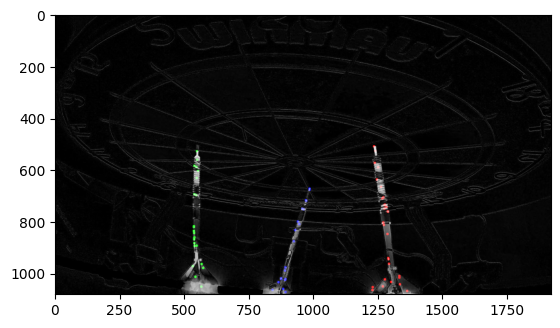

In [78]:
#Print out the results of the functions

def main(dartFrame, emptyFrame):
    gray_dart = cv2.cvtColor(dartFrame, cv2.COLOR_BGR2GRAY)
    gray_empty = cv2.cvtColor(emptyFrame, cv2.COLOR_BGR2GRAY)
    difference = cv2.absdiff(gray_dart, gray_empty) 
    difference = cv2.cvtColor(difference, cv2.COLOR_GRAY2BGR)

    mask1 = prepareMask(dartFrame, emptyFrame)

    mask2 = np.zeros_like(mask1)
    centroids = findPointsInMask(mask1, 10)
    for (cx, cy) in centroids:
        cv2.circle(mask2, (cx, cy), 5, (255, 0, 0), -1)

    groups = groupDots(centroids)
    darts = findDartPositions(groups)

    print(darts)

    colors = [
        (255, 0, 0),
        (0, 255, 0),
        (0, 0, 255)
    ]

    mask3 = np.zeros_like(dartFrame_og)
    for index, group in enumerate(groups):
        color = colors[index % len(colors)] 
        for (cx, cy) in group:
            cv2.circle(mask3, (cx, cy), 5, color, -1)

    result_image = cv2.add(mask3, difference)

    cv2.imwrite('difference.jpg', difference)
    cv2.imwrite('mask1.jpg', mask1)
    cv2.imwrite('mask2.jpg', mask2)
    cv2.imwrite('mask3.jpg', mask3)
    cv2.imwrite('result.jpg', result_image)
    plt.imshow(result_image)
    plt.show()

dartFrame_og = cv2.imread('darts.jpg')
emptyFrame_og = cv2.imread('empty.jpg')

#main(dartFrame_og, emptyFrame_og) #Funktioniert

dartFrame_top = cv2.imread('./images/dart_top.jpg')
emptyFrame_top = cv2.imread('./images/empty_top.jpg')

main(dartFrame_top, emptyFrame_top) 